In [16]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from riboformer_utils import *

# dataset to reproduce the results could be downloaded here: 
# https://drive.google.com/file/d/1B5RV_74uPLYjpakOdUmH03_NMP0hQXrB/view?usp=sharing

# Set all the parameters
file_paths = {
    'data_folder': './Datasets/GSE77617_His/',
    'exp1': 'GSM2055244_rib_37_WT',
    'exp2': 'GSM2462934_rib_CUA',
    'exp3': 'GSM2462935_rib_CUG',
    'exp4': 'GSM2462933_rib_CTRL',
    'DMS': 'GSM2055270_DMS_WT',
    'gff_name': 'NC000913.2_gff_2.csv',
    'seq_name': 'NC_000913.2.fasta',
}

file_io = {
    'x_input': '_new_codon_xc_new.txt',
    'y_output': '_new_codon_yc_new.txt',
    'z_index': '_new_codon_zc_new.txt',
    'y_pred': '_new_codon_y_pred.txt',
}

suffixes = ["_for.wig", "_rev.wig"]
pause_score_benchmark = {}
L_score_benchmark0 = {}
L_score_benchmark1 = {}

# Read the DNA sequence and the GFF file
sequence_iter = fasta_iter(file_paths['data_folder'] + file_paths['seq_name'])
for header, seq in sequence_iter:
    print("Genome seq length:", len(seq))

annotations = np.genfromtxt(file_paths['data_folder'] + file_paths['gff_name'], delimiter=",")

NC_000913.2 Escherichia coli str. K-12 substr. MG1655, complete genome
Genome seq length: 4639675


#### Import dataset from GSE77617

In [3]:

def process_experiment(exp_name, file_paths, file_io, suffixes, annotations, seq, pause_scores_aa):
    """Process an experiment by calculating pause scores and returning the results."""
    densities = read_gene_densities(file_paths['data_folder'], file_paths[exp_name], suffixes)
    zc = np.loadtxt(file_paths['data_folder'] + file_paths[exp_name] + file_io['z_index'], delimiter="\t")
    ypred = np.loadtxt(file_paths['data_folder'] + 'Sym_' + file_paths[exp_name] + file_io['y_pred'], delimiter="\t")

    # Input 6 -> E site, 3 -> P site, 0 -> A site
    pause_scores_1 = get_pause_score(0, 0, densities, annotations, seq, ypred, zc, np.arange(len(annotations)), pred=1)
    pause_scores_0 = get_pause_score(0, 0, densities, annotations, seq, ypred, zc, np.arange(len(annotations)), pred=0)

    pause_scores_aa = {k: pause_scores_aa[k] for k in sorted(pause_scores_aa)}
    pause_scores_total = []

    for k in pause_scores_aa.keys():
        codon_0_scores = [np.append([], pause_scores_0[s]) for s in pause_scores_aa[k]]
        codon_1_scores = [np.append([], pause_scores_1[s]) for s in pause_scores_aa[k]]
        pause_scores_total.append([np.mean(np.concatenate(codon_0_scores)), np.mean(np.concatenate(codon_1_scores))])

    H_codon_list = ['CTA', 'CTG', 'CTC', 'CTT', 'TTA', 'TTG']
    l_scores_0 = [np.mean(pause_scores_0[s]) for s in H_codon_list]
    l_scores_1 = [np.mean(pause_scores_1[s]) for s in H_codon_list]

    return np.array(pause_scores_total).transpose(), l_scores_0, l_scores_1

# Read the ribosome footprints
experiment_names = ['exp2', 'exp3', 'exp4']

for experiment_name in experiment_names:
    pause_scores, l_scores_0, l_scores_1 = process_experiment(experiment_name, file_paths, file_io, suffixes, annotations, seq, pause_scores_aa)
    pause_score_benchmark[experiment_name] = pause_scores
    L_score_benchmark0[experiment_name] = l_scores_0
    L_score_benchmark1[experiment_name] = l_scores_1


#### reproduce figure 1g

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


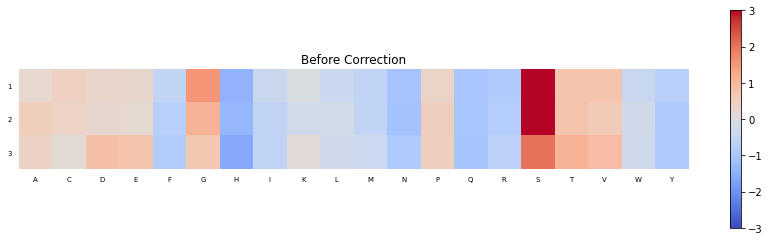

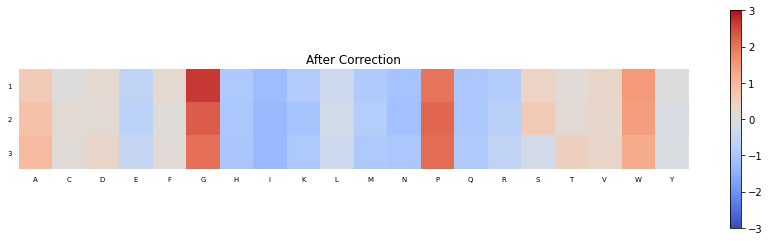

In [4]:
def plot_pause_scores(pause_scores, title, pause_score_keys):
    """Plot the pause scores using a heatmap."""
    pause_scores_normalized = (pause_scores - np.average(pause_scores)) / np.std(pause_scores)

    fig, ax = plt.subplots(figsize=(15, 4))
    im = ax.imshow(pause_scores_normalized, cmap='coolwarm')
    ax.set_xticks(np.arange(len(pause_score_keys)))
    ax.set_xticklabels(labels=pause_score_keys, fontsize=7)
    ax.set_yticks(np.arange(3))
    ax.set_yticklabels(np.arange(1, 4))
    plt.xticks(fontname="Helvetica", fontsize=7)
    plt.yticks(fontname="Helvetica", fontsize=7)
    cbar = fig.colorbar(im, ax=ax)
    im.set_clim(-3, 3)
    ax.tick_params(left=False, bottom=False)
    plt.box(False)
    plt.title(title)
    plt.show()

# Create pause score heatmaps
exp_names = ['exp4', 'exp2', 'exp3']
pause_scores_aa = {k: pause_scores_aa[k] for k in sorted(pause_scores_aa)}
pause_score_keys = list(pause_scores_aa.keys())

for i, score_type in enumerate(["Before", "After"]):
    pause_scores = np.vstack([pause_score_benchmark[exp_name][i, :] for exp_name in exp_names])
    plot_pause_scores(pause_scores, f"{score_type} Correction", pause_score_keys)


#### reproduce figure 1f

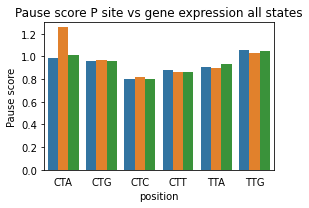

In [5]:
def plot_pause_score_bar_chart(pause_scores, codon_list, title):
    """Plot the pause scores as a bar chart."""
    df = pd.DataFrame(pause_scores)
    df = df[['exp4', 'exp2', 'exp3']]
    yaxis_name = 'Pause score'
    df_long = df.melt(var_name='strain', value_name=yaxis_name)
    df_long['position'] = codon_list * 3

    fig, ax = plt.subplots(figsize=(4, 3))
    sns.barplot(x='position', y=yaxis_name, hue='strain', data=df_long)

    plt.ylim([0, 1.3])
    plt.legend([], [], frameon=False)
    plt.title(title)
    fig.tight_layout()
    ax.tick_params(bottom=False)
    plt.show()

# Create the bar chart of pause scores
H_codon_list = ['CTA', 'CTG', 'CTC', 'CTT', 'TTA', 'TTG']
plot_pause_score_bar_chart(L_score_benchmark1, H_codon_list, 'Pause score P site vs gene expression all states')


#### import the DMS-seq datasets

In [7]:
def calculate_dms_score(filepath, file_io, exp_name, dwig_suffix, annotations, seq):
    """Calculate the DMS score."""
    zc_dms = np.loadtxt(filepath['data_folder'] + filepath[exp_name] + file_io['z_index'], delimiter="\t")
    ypred_dms = np.loadtxt(filepath['data_folder'] + 'Sym_' + filepath[exp_name] + file_io['y_pred'], delimiter="\t")
    xc_dms = np.loadtxt(filepath['data_folder'] + filepath[exp_name] + file_io['x_input'], delimiter="\t")

    # Analyze the DMS dataset
    exp_name = 'DMS'
    dwig_dms = read_gene_densities(filepath['data_folder'], filepath[exp_name], dwig_suffix)

    dms_score = np.zeros(ypred_dms.shape)
    for i in range(len(zc_dms)):
        index = zc_dms[i, :].astype('int')
        if annotations[index[0]][2] == 1:
            w_temp = dwig_dms[int(annotations[index[0]][0]) - 1:(int(annotations[index[0]][1])), 1]
            dms_score[i] = sum(w_temp[3 * (index[1] - 10):3 * (index[1] - 10) + 3])
        else:
            w_temp = dwig_dms[int(annotations[index[0]][0]) - 1:(int(annotations[index[0]][1])), 2]
            w_temp = w_temp[::-1]
            dms_score[i] = sum(w_temp[3 * (index[1] - 10):3 * (index[1] - 10) + 3])

    return dms_score, xc_dms, ypred_dms

# Calculate the ribosome density for DMS datasets
exp_name_dms = 'exp1'
dms_score, xc_dms, ypred_dms = calculate_dms_score(file_paths, file_io, exp_name_dms, suffixes, annotations, seq)


#### reproduce supp figure 3

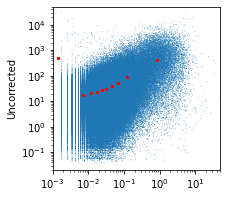

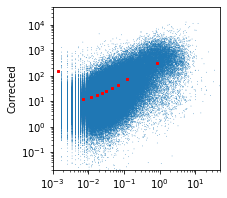

In [8]:
def plot_dms_scatter(dms_score, data, ylabel):
    fig, ax = plt.subplots(figsize=(3, 3))
    plt.scatter(dms_score, data, s=0.5, c='#1f77b4', edgecolors='none')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([0.02, 50000])
    plt.xlim([0.001, 50])

    dms_score_sort = np.argsort(dms_score)
    dms_sorted = np.array_split(dms_score_sort, 10)
    scatter_sorted = np.array([[np.mean(dms_score[x]), np.mean(data[x])] for x in dms_sorted])

    plt.plot(scatter_sorted[:, 0], scatter_sorted[:, 1], 's', color='red', markersize=2)
    plt.ylabel(ylabel)
    plt.show()

# Plot the first scatter plot
plot_data1 = (np.power(2, xc_dms[:, 20] / 100) - 32) / 10
plot_dms_scatter(dms_score, plot_data1, 'Uncorrected')

# Plot the second scatter plot
plot_data2 = (np.power(2, ypred_dms + 5) - 32) / 10
plot_dms_scatter(dms_score, plot_data2, 'Corrected')


#### Analysis the trmD dataset (GSE165592)

In [12]:
# Set all the parameters
filepath = {
    'data_folder': './Datasets/GSE165592_trmD/',
    'exp1': 'GSM5044532_trmD_control_FP1',
    'exp2': 'GSM5044533_trmD_degron_FP1',
    'exp3': 'GSM2462935_rib_CUG',
    'exp4': 'GSM2462933_rib_CT,RL',
    'rnaexp': 'GSM5044534_trmD_control_RNAseq1',
    'DMS': 'GSM2055270_DMS_WT',
    'gff_name': 'NC000913.2.csv',
    'seq_name': 'NC000913.2.fasta',
}

fileio = {
    'x_input': '_new_codon_xc_new.txt',
    'y_output': '_new_codon_yc_new.txt',
    'z_index': '_new_codon_zc_new.txt',
    'y_pred': '_new_codon_y_pred.txt',
}

# Import source data
dwig1 = read_gene_densities2(filepath['data_folder'], filepath['exp1'])
dwig2 = read_gene_densities2(filepath['data_folder'], filepath['exp2'])

# Import gff
annotations = np.genfromtxt(filepath['data_folder'] + filepath['gff_name'], delimiter=",")

# Import genome sequence
sequence_iter = fasta_iter(file_paths['data_folder'] + file_paths['seq_name'])
for header, seq in sequence_iter:
    print("Genome seq length:", len(seq))

print("Finish loading the reads data and sequence")

NC_000913.2 Escherichia coli str. K-12 substr. MG1655, complete genome
Genome seq length: 4639675
Finish loading the reads data and sequence


In [13]:
# Load the data for the control experiment in the GSE165592 dataset
zc_control = np.loadtxt(filepath['data_folder'] + filepath['exp1'] + fileio['z_index'], delimiter="\t")
ypred_control = np.loadtxt(filepath['data_folder'] + 'New_40AA_Crl_Deg_new_codon_y_pred.txt', delimiter="\t")
pause_score_c0 = get_pause_score(11, 14, dwig1, annotations, seq, ypred_control, zc_control, np.arange(len(annotations)), pred=0)
pause_score_c1 = get_pause_score(11, 14, dwig1, annotations, seq, ypred_control, zc_control, np.arange(len(annotations)), pred=1)

# Load the data for the degron experiment in the GSE165592 dataset
# Analyze pause score in the A site
zc_degron = np.loadtxt(filepath['data_folder'] + filepath['exp2'] + fileio['z_index'], delimiter="\t")
ypred_degron = np.loadtxt(filepath['data_folder'] + 'New_40AA_Deg_Crl_new_codon_y_pred.txt', delimiter="\t")
pause_score_d0 = get_pause_score(11, 14, dwig2, annotations, seq, ypred_degron, zc_degron, np.arange(len(annotations)), pred=0)
pause_score_d1 = get_pause_score(11, 14, dwig2, annotations, seq, ypred_degron, zc_degron, np.arange(len(annotations)), pred=1)


#### reproduce supp figure 2

C:\Users\lingx\AppData\Local\Temp/ipykernel_5444/1711168357.py:21: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=2)
C:\Users\lingx\AppData\Local\Temp/ipykernel_5444/1711168357.py:22: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', basey=2)


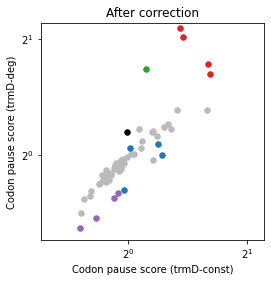

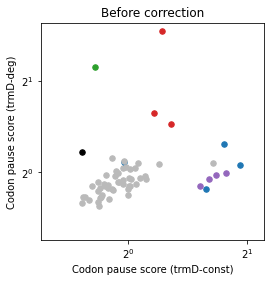

In [14]:
def plot_codon_pause_scores(pause_scores_c, pause_scores_d, codon_table, y_lim_upper, title):
    stop_codons = ['TAG', 'TGA', 'TAA']
    fig, ax = plt.subplots(figsize=(4, 4))
    
    for codon in codon_table:
        if codon not in stop_codons:
            if codon.startswith('CC'):
                color = '#d62728'
            elif codon.startswith('GG'):
                color = '#1f77b4'  # cyan
            elif codon.startswith('TC'):
                color = '#9467bd'  # purple
            elif codon == 'CGG':
                color = '#2ca02c'
            elif codon == 'CTA':
                color = 'black'
            else:
                color = '#BABABA'
            ax.scatter(np.mean(pause_scores_c[codon]), np.mean(pause_scores_d[codon]), s=30, c=color)
    
    plt.xscale('log', basex=2)
    plt.yscale('log', basey=2)
    plt.xlim([0.6, 2.2])
    plt.ylim([0.6, y_lim_upper])
    plt.xlabel('Codon pause score (trmD-const)')
    plt.ylabel('Codon pause score (trmD-deg)')
    plt.title(title)
    plt.show()

# Call the function for 'After correction' plot
plot_codon_pause_scores(pause_score_c1, pause_score_d1, codon_table, 2.2, 'After correction')

# Call the function for 'Before correction' plot
plot_codon_pause_scores(pause_score_c0, pause_score_d0, codon_table, 3.1, 'Before correction')


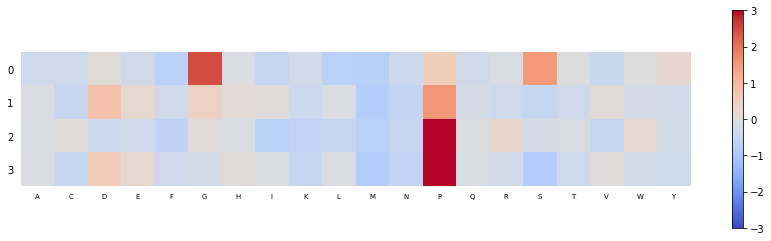

In [15]:
def plot_heatmap(pause_scores_c0, pause_scores_c1, pause_scores_d0, pause_scores_d1, pause_scores_aa):
    pause_scores_aa = {k: pause_scores_aa[k] for k in sorted(pause_scores_aa)}
    pause_score_totals = []
    
    for k in pause_scores_aa.keys():
        codon_c0 = [pause_scores_c0[s] for s in pause_scores_aa[k]]
        codon_c1 = [pause_scores_c1[s] for s in pause_scores_aa[k]]
        codon_d0 = [pause_scores_d0[s] for s in pause_scores_aa[k]]
        codon_d1 = [pause_scores_d1[s] for s in pause_scores_aa[k]]
        pause_score_totals.append([np.mean(np.concatenate(codon_c0)), np.mean(np.concatenate(codon_c1)),
                                   np.mean(np.concatenate(codon_d0)), np.mean(np.concatenate(codon_d1))])
    
    pause_score_totals = np.array(pause_score_totals)
    pause_score_totals = (pause_score_totals - np.average(pause_score_totals)) / np.std(pause_score_totals)
    
    fig, ax = plt.subplots(figsize=(15, 4))
    im = ax.imshow(pause_score_totals.transpose(), cmap='coolwarm')
    ax.set_xticks(np.arange(len(pause_scores_aa.keys())))
    ax.set_xticklabels(labels=pause_scores_aa.keys(), fontsize=7)
    cbar = fig.colorbar(im, ax=ax)
    ax.tick_params(left=False, bottom=False)
    im.set_clim(-3, 3)
    plt.box(False)
    plt.show()

# Call the function with the appropriate pause score dictionaries
plot_heatmap(pause_score_c0, pause_score_c1, pause_score_d0, pause_score_d1, pause_scores_aa)
